In [23]:
import sys
import os
import time
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm
import json
from typing import Tuple


In [24]:
# 获取域名元数据
metad = {}
with open("/root/Workspace/DWTF/domain_relation/src/secrank1k-metadata.txt","r") as inf:
    for line in tqdm(inf.readlines(), desc="Get domains' meta data"):
        td = eval(line.strip())
        metad[td['sld']] = td

Get domains' meta data:   0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
## 更新入度信息
def upgrade_in_degree(G):
    for n in G.nodes():
        nx.set_node_attributes(G, {n:{'indegree':G.in_degree(n)}})

In [26]:
## 有向图转json
def graph2json(G):
    #改用默认的方法
    upgrade_in_degree(G)
    res = json_graph.node_link_data(G)
    del res["directed"]
    del res["multigraph"]
    del res["graph"]
    return res

    
    # d = {'nodes':[], 'links':[]}
    # # 节点信息
    # for n in G.nodes():
    #     tj = G.nodes.data()[n]
    #     tj['id'] = n
    #     tj['indegree'] = G.in_degree(n)
    #     d['nodes'].append(tj)
    # # 边信息
    # d['links'] = [{'source': u, 'target': v, 'color':G.edges[u,v]['color']} for u, v in G.edges()]
    # return d

In [27]:
## 去除自环
def wipecycle(G):
    remove_edges = []
    for u,v in G.edges():
        if u == v:
            remove_edges.append((u,v))
    for i in remove_edges:
        G.remove_edge(i[0], i[1])

In [28]:
# 给图增加其他元数据
def addmetadata(G):
    for n in tqdm(G.nodes(), desc="Add mate data to josn"):
            try:
                nx.set_node_attributes(G, {n:{'requestCount': metad[n]['requestCount']}})
                nx.set_node_attributes(G, {n:{'clientIpCount': metad[n]['clientIpCount']}})
                nx.set_node_attributes(G, {n:{'subdomainCount': metad[n]['subdomainCount']}})
            except Exception as e:
                pass

In [29]:
# 增加点和线的颜色属性

## 增加默认的绿色属性
def addg(G):
    # 添加节点属性
    for i in G.nodes():
        nx.set_node_attributes(G, {i:{'color':'green'}})
    # 添加边的属性
    for e in G.edges():
        nx.set_edge_attributes(G, {e:{'color':'green'}})

def addr(G, breakN, breakE):
    # 更改节点属性
    for i in breakN:
        nx.set_node_attributes(G, {i:{'color':'red'}})
    # 更改边的属性
    for e in breakE:
        nx.set_edge_attributes(G, {e:{'color':'red'}})

In [30]:
## block一个域名，返回受影响的线和边，直接修改颜色信息

#按照颜色删除点和边
def Gc2Gn(G:nx.DiGraph()) -> nx.DiGraph():
    Gn = G.copy()
    # 删除红色的边
    for u, v, data in Gn.edges(data=True):
        if data['color'] == 'red':
            G.remove_edge(u, v)

    # 删除Red节点
    for node in list(G.nodes()):
        if G.nodes[node]['color'] == 'red':
            G.remove_node(node)
    return Gn

def blockdomain(G, domainname):
    # 复制该有向图，将Red点和边统统删去    
    Gn = Gc2Gn(G)
    blockedNode = blockAdomain(Gn, domainname=domainname)
    #更新图，把删掉的点及其边更新为属性值
    for node in list(blockedNode):
        nx.set_node_attributes(G, {node: {'color': 'red'}})
        for u, v in G.out_edges(node):
            G[u][v]['color'] = 'red'
        for u, v in G.in_edges(node):
            G[u][v]['color'] = 'red'
    
def blockAdomain(G, domainname):
    G = G.reverse()
    # print("[++++++]"+domainname+" blocked !")
    # 定义不可用的节点
    unavailable_node = domainname
    # 第一次深度优先搜索
    reachable1 = set(nx.dfs_preorder_nodes(G, source="."))
    # 删除该节点及其边
    G.remove_node(unavailable_node)
    # 第二次深度优先搜索
    reachable2 = set(nx.dfs_preorder_nodes(G, source="."))
    # 求差集
    unreachable = reachable1 - reachable2
    return unreachable
   

In [31]:
## 提取指定有向图，输出默认颜色（green）的json文件
import networkx as nx
from networkx.readwrite import json_graph
from pprint import pprint

tars = ['edu', 'gov', 'other']
nxs = {}
for i in tars:
    nxs[i] = pickle.load(open("/root/Workspace/DWTF/domain_relation/data/%s.graph_set_global.bin" % i, "rb"))

wc = True

for u,v in nxs.items():
    if wc:
        wipecycle(v['general'])
    # 添加其他元数据
    addmetadata(v['general'])
    #增加默认的颜色属性
    addg(v['general'])
    # 转json
    j = graph2json(v['general'])

    json_data = json.dumps(j, indent=4)
    with open("../data/%s.graph_set_global.json"%u, "w+") as ouf:
        ouf.write(json_data)



Add mate data to josn:   0%|          | 0/175 [00:00<?, ?it/s]

Add mate data to josn:   0%|          | 0/215 [00:00<?, ?it/s]

Add mate data to josn:   0%|          | 0/332 [00:00<?, ?it/s]

In [32]:
# block掉某个域名后的情况
import sys
# sys.setrecursionlimit(50000)

ggg = nxs['edu']['general']
blockdomain(ggg, 'edu.cn')

j = graph2json(ggg)
json_data = json.dumps(j, indent=4)
with open("../data/%s.graph_set_global.block.%s.json"%("edu", "edu.cn"), "w+") as ouf:
    ouf.write(json_data)
    
    
#######################
ggg = nxs['gov']['general']
blockdomain(ggg, 'afilias-nst.org')

j = graph2json(ggg)
json_data = json.dumps(j, indent=4)
with open("../data/%s.graph_set_global.block.%s.json"%("gov", "afilias-nst.org"), "w+") as ouf:
    ouf.write(json_data)
    
#######################
ggg = nxs['other']['general']
blockdomain(ggg, 'com')

j = graph2json(ggg)
json_data = json.dumps(j, indent=4)
with open("../data/%s.graph_set_global.block.%s.json"%("other", "com"), "w+") as ouf:
    ouf.write(json_data)

In [33]:
def delRed(G):     
    delN = []
    for n in G.nodes():
        if G.nodes[n]['color'] == 'red':
            delN.append(n)
    for i in delN:
        G.remove_node(i)
    delE = []
    for e in G.edges():
        if G.edges[e]['color'] == 'red':
            delE.append(e)
    for j in delE:
        G.remove_edge(j)

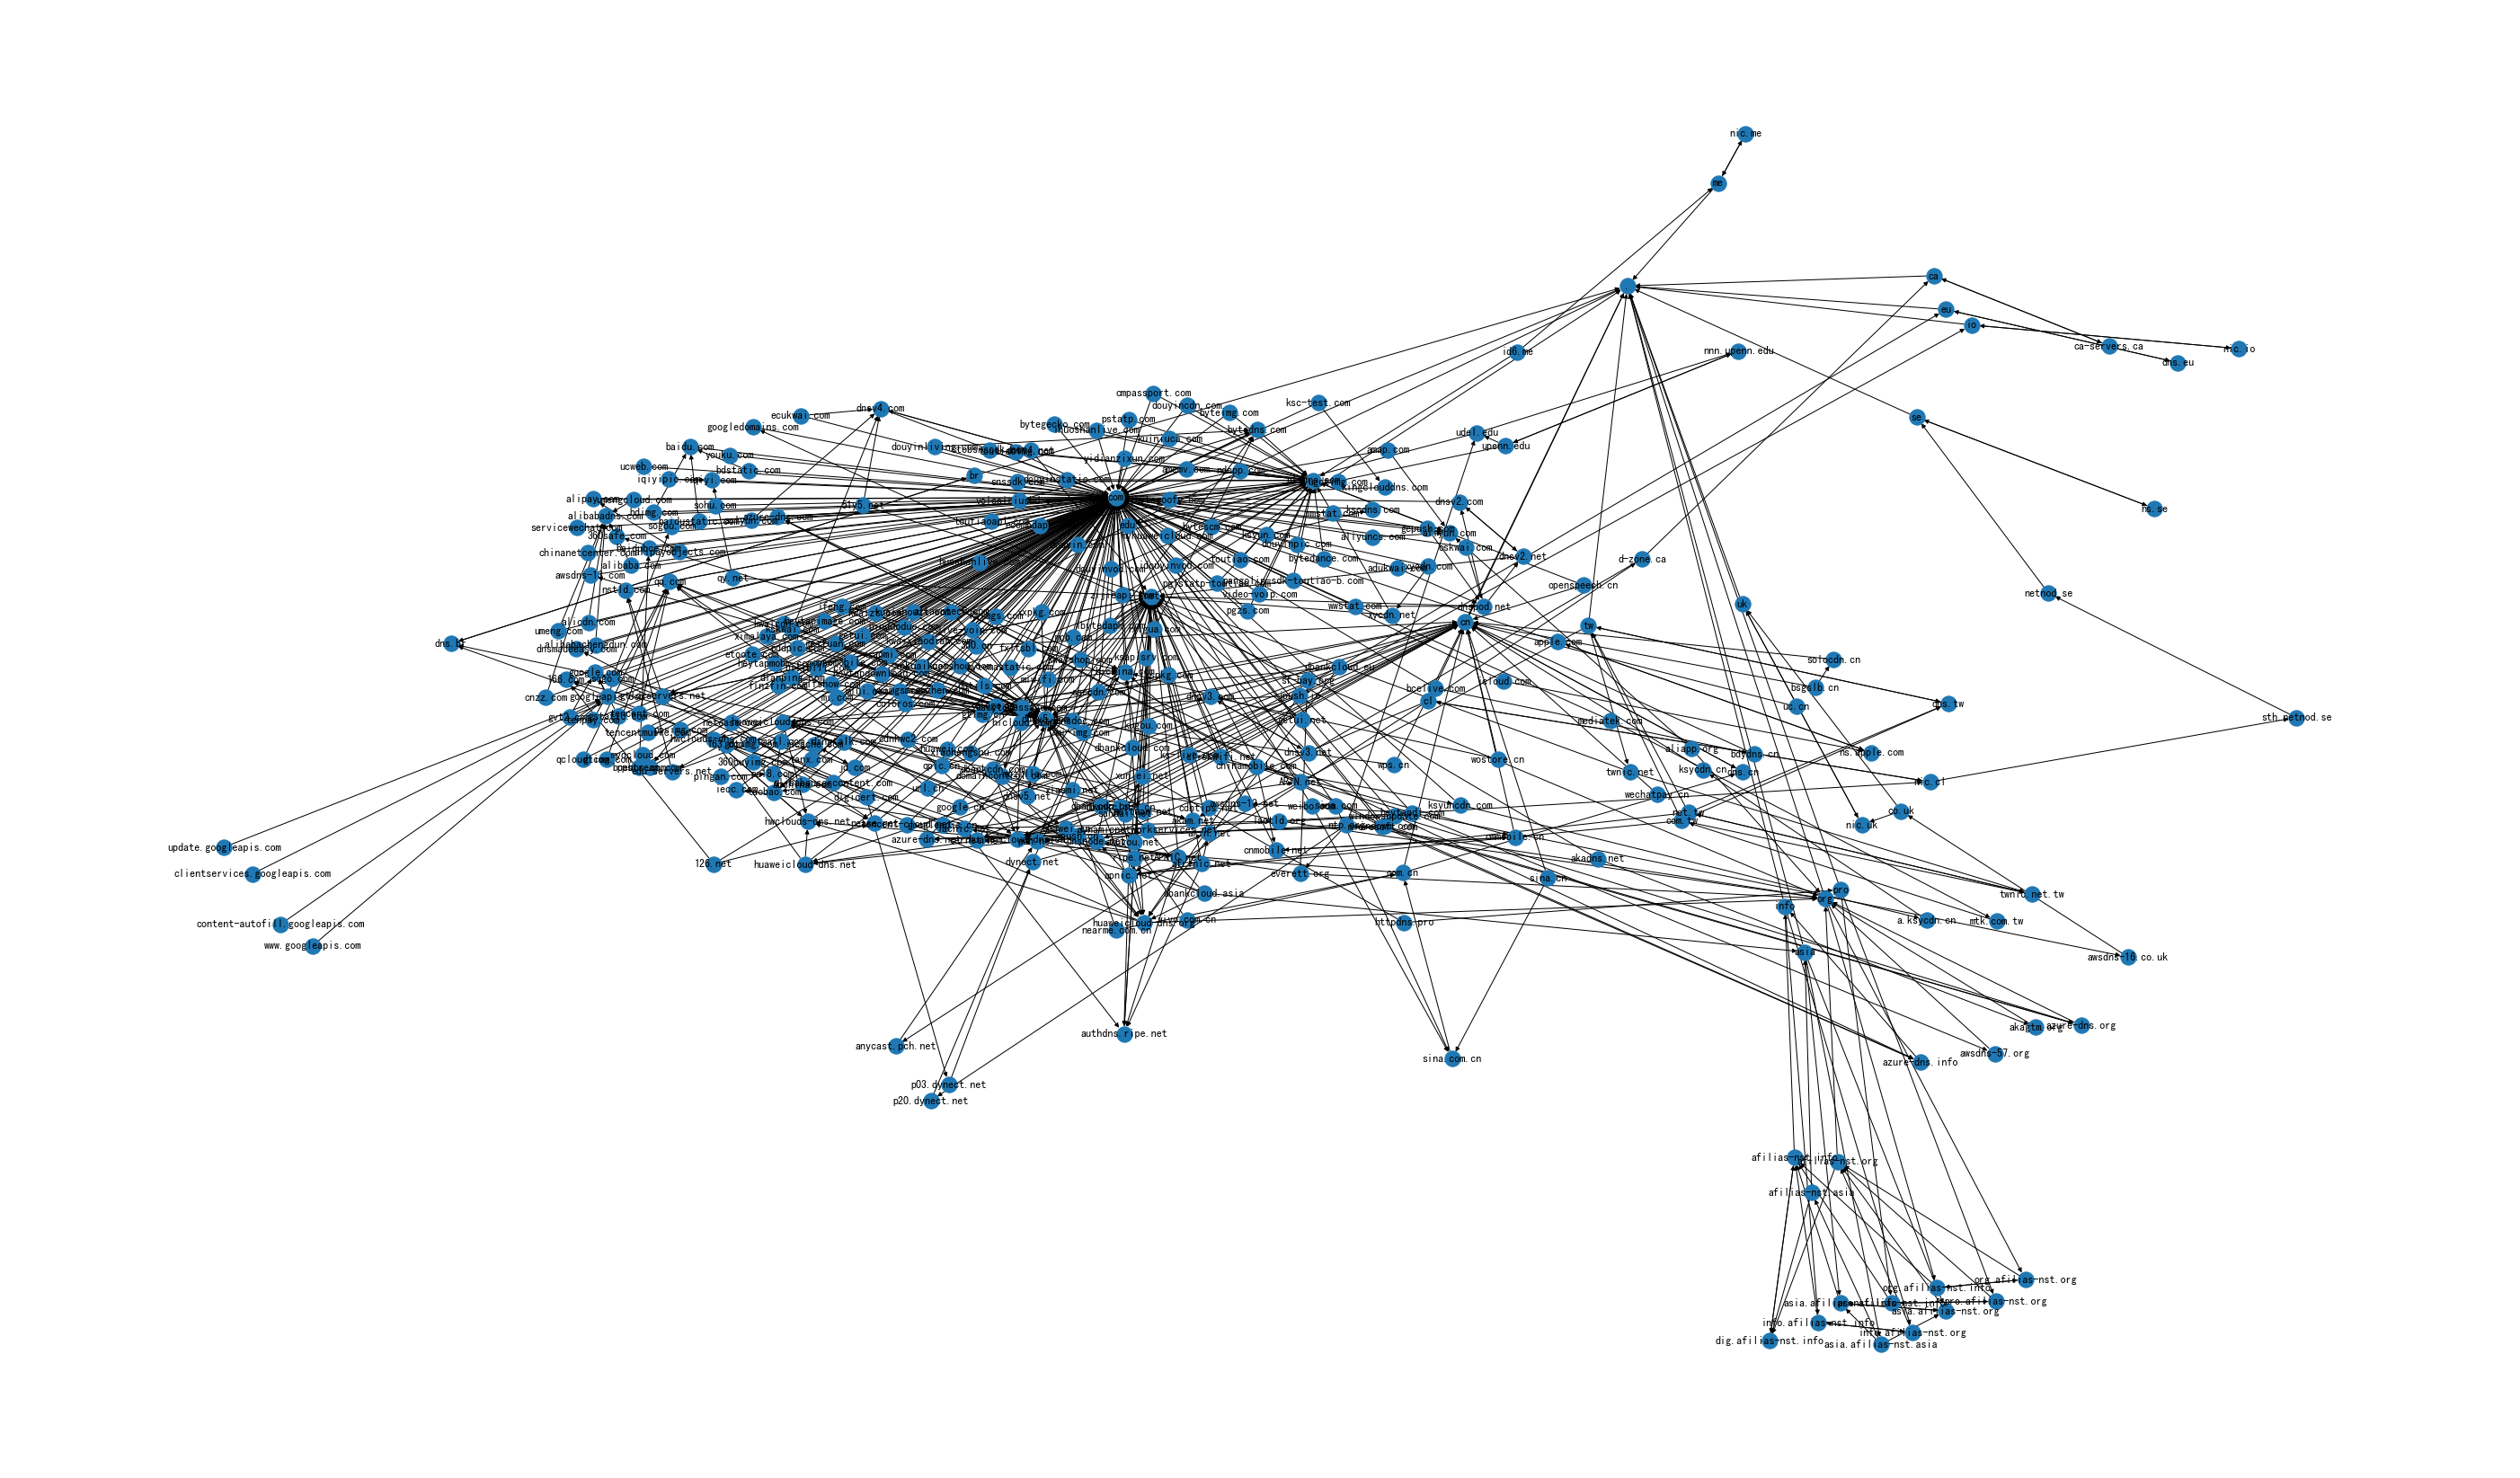

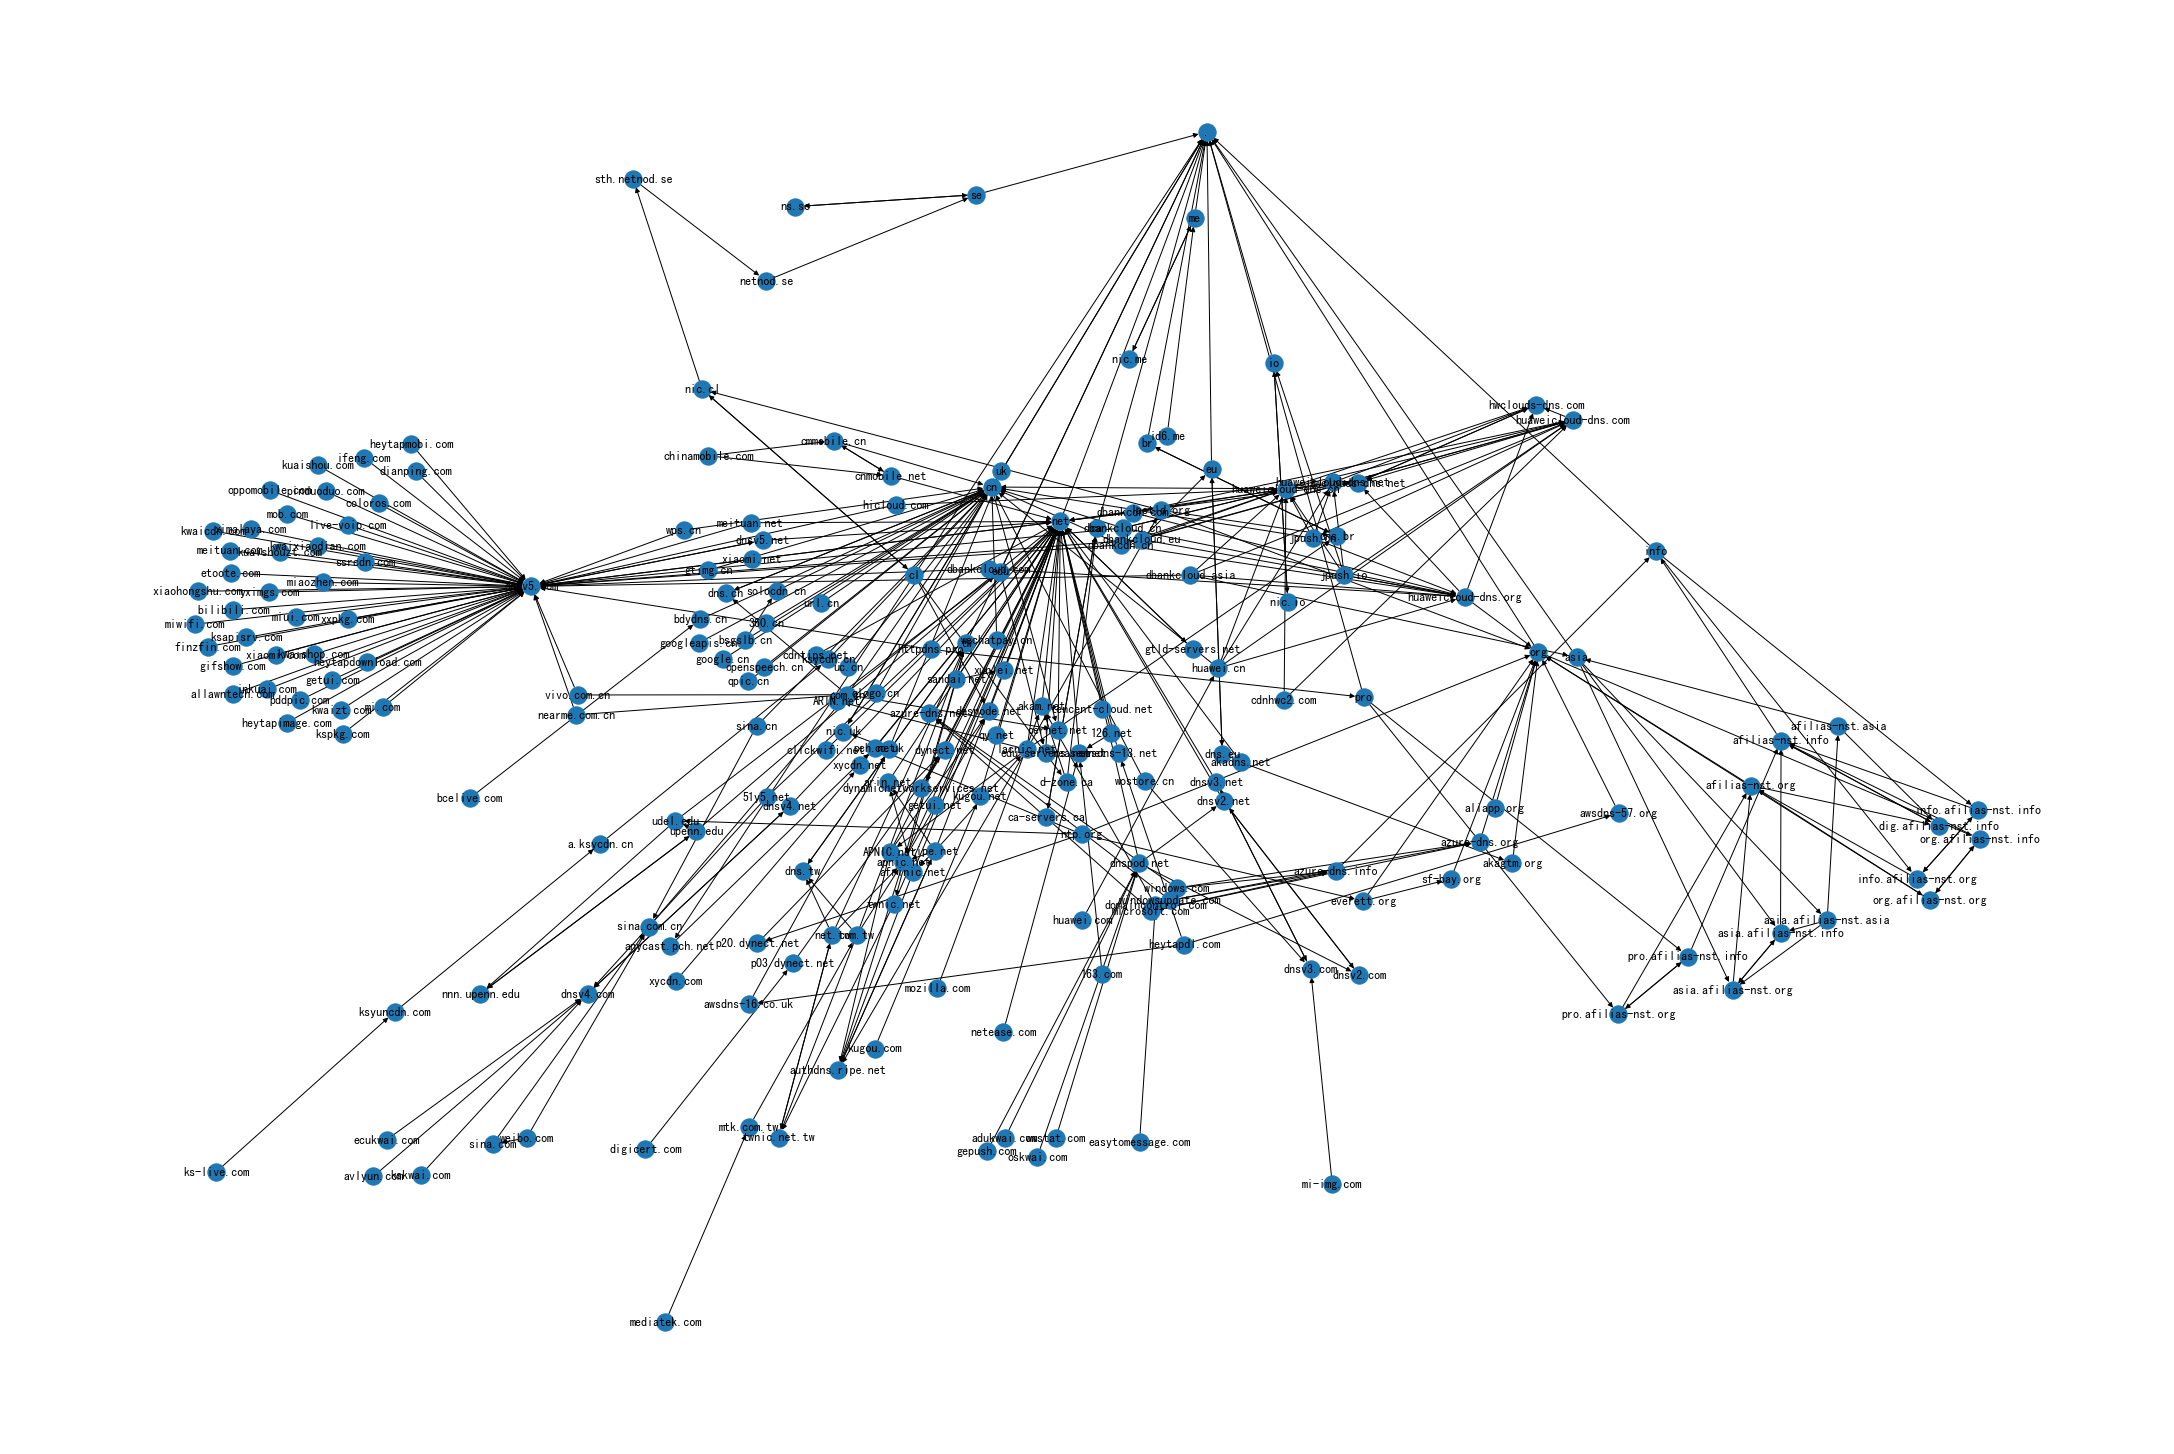

In [34]:
# 绘图
fig = plt.figure(figsize=(50, 30))
ax = fig.add_subplot(111)
nx.draw_spring(ggg, with_labels=True, ax=ax)
plt.show()

delRed(ggg)

plt.figure(figsize=(30, 20))
nx.draw_spring(ggg, with_labels=True)
plt.show()
